# Python Basics


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import datetime



In [23]:


csvFileAddress = 'csv/12M/FTSE100_M12_201906030124_202212132324.csv'

DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ['<ISGREEN>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<CLOSE>'] - DJ['<OPEN>']
DJ['<VOLATILITY>'] =  DJ['<HIGH>'] - DJ['<LOW>']

DJ.drop(['<VOL>'],axis=1,inplace=True)



In [24]:
timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) ) * 60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)

In [25]:
timeFrame

12

In [26]:
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newnumparr = np.full((uniqueDaysCount*CandlesInDay,2),'',dtype=np.object_)


for i in range(uniqueDaysCount):
    for j in range(CandlesInDay):
        newnumparr[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j)]

newDF = pd.DataFrame(newnumparr,columns=['<DATE>','<TIME>'])


In [27]:

newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

# newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<VOLATILITY>_x','<ISGREEN>_x'],inplace=True)
newestDF.fillna(0,inplace=True)

newestDF['<EMA30>']= ta.trend.ema_indicator( newestDF['<CLOSE>'],window=30)
newestDF['<EMA50>']= ta.trend.ema_indicator( newestDF['<CLOSE>'],window=50)
newestDF['<EMA200>']= ta.trend.ema_indicator( newestDF['<CLOSE>'],window=200)

def Upper(e):
    if e['<ISGREEN>'] : 
        return e['<HIGH>']-e['<CLOSE>']
    return e['<HIGH>']-e['<OPEN>']

def Lower(e):
    if e['<ISGREEN>'] : 
        return e['<OPEN>']-e['<LOW>']
    return e['<CLOSE>']-e['<LOW>']


newestDF['<UPPER>'] = newestDF.apply(Upper,axis=1)
newestDF['<LOWER>'] = newestDF.apply(Lower,axis=1)




In [28]:
# Compute RSI

newestDF['<RSI>'] = ta.momentum.rsi(newestDF['<CLOSE>'],window=15) / 100
newestDF['<CCI>'] = ta.trend.cci(close=newestDF['<CLOSE>'],high=newestDF['<HIGH>'],low=newestDF['<LOW>'],window=14)


keltner = ta.volatility.KeltnerChannel(close=newestDF['<CLOSE>'],high=newestDF['<HIGH>'],low=newestDF['<LOW>'],window=20,window_atr=10,multiplier=2.5)
newestDF['<KELTNER_H>'] = keltner.keltner_channel_hband()
newestDF['<KELTNER_L>'] = keltner.keltner_channel_lband()
newestDF['<KELTNER_M>'] = keltner.keltner_channel_mband()


newestDF['<ATR_24>'] = ta.volatility.average_true_range(close=newestDF['<CLOSE>'],high=newestDF['<HIGH>'],low=newestDF['<LOW>'],window=12).apply(lambda e : e/100)


newestDF["<GREEN>"] = newestDF["<ISGREEN>"].astype(int)




# (newestDF,open="<OPEN>",close='<CLOSE>',high='<HIGH>',low='<LOW>',volume='<TICKVOL>',)

In [29]:
newestDF

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<SPREAD>,<ISGREEN>,<SIZE>,...,<EMA200>,<UPPER>,<LOWER>,<RSI>,<CCI>,<KELTNER_H>,<KELTNER_L>,<KELTNER_M>,<ATR_24>,<GREEN>
0,2019.06.03,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
1,2019.06.03,00:12:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
2,2019.06.03,00:24:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
3,2019.06.03,00:36:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
4,2019.06.03,00:48:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107395,2022.12.13,23:00:00,7495.2,7501.2,7490.2,7497.2,368.0,25.0,True,2.0,...,7172.550418,4.0,5.0,0.516298,43.889227,7502.498333,7481.208333,7491.853333,0.116668,1
107396,2022.12.13,23:12:00,7496.7,7499.2,7492.2,7492.7,238.0,25.0,False,-4.0,...,7175.735986,2.5,0.5,0.491867,14.029386,7502.210000,7481.920000,7492.065000,0.112779,0
107397,2022.12.13,23:24:00,7493.7,7494.2,7491.2,7494.2,98.0,25.0,True,0.5,...,7178.904782,0.0,2.5,0.500312,-13.414305,7502.106667,7482.776667,7492.441667,0.105881,1
107398,2022.12.13,23:36:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,7107.472894,0.0,0.0,0.005561,-466.666667,7127.475000,7108.895000,7118.185000,6.342224,0


In [30]:
list = []
for i in range(len(newestDF)):
    date = newestDF.iloc[i]["<DATE>"]
    time = newestDF.iloc[i]["<TIME>"]
    isGreen = newestDF.iloc[i]["<ISGREEN>"]
    size = newestDF.iloc[i]["<SIZE>"]
    low = newestDF.iloc[i]["<LOW>"]
    high = newestDF.iloc[i]["<HIGH>"]
    volatility = newestDF.iloc[i]["<VOLATILITY>"]
    atr = newestDF.iloc[i]['<ATR_24>']
    
    list.append([date, time, isGreen, size,low,high, volatility,atr])


In [31]:
days = []
daysDfs = []
for i in range(uniqueDaysCount): 
    daysDfs.append(pd.DataFrame(list[i*CandlesInDay: CandlesInDay*(i+1)],columns=[
        'date',
'time',
'isGreen',
'size',
'low',
'high',
'volatility',
'atr',
    ]))
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


In [32]:
daysDfs[34]

maxList=np.zeros(CandlesInDay)
minList=np.zeros(CandlesInDay)


for i in (daysDfs):
    sth = i.loc[~((i['low'] == 0))]
    minList[(sth['low'].idxmin())]+=1
    maxList[(sth['low'].idxmin())]+=1



<BarContainer object of 120 artists>

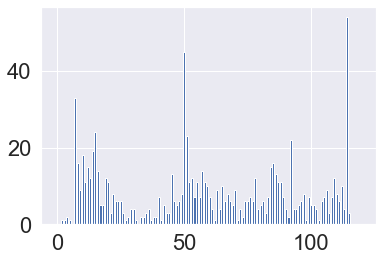

In [33]:
plt.bar(x=range(CandlesInDay),height=maxList)

<BarContainer object of 120 artists>

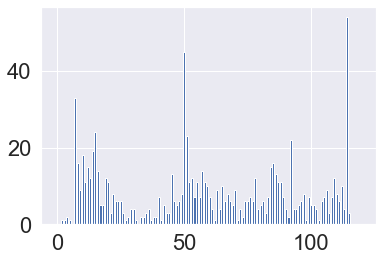

In [34]:
plt.bar(x=range(CandlesInDay),height=minList)

In [48]:
avgMultiplier = float(input('Only calculate candles bigger than X times the average (def=1) :' )or '1')

def eachDayMatrix(day):
    
    avgCandleBodySize=0
    avgCandleVolatility=0

    for i in range(len(day)):
        avgCandleBodySize+=abs(day[i][3])
        avgCandleVolatility+=abs(day[i][6])
    
    avgCandleBodySize/=len(day)
    avgCandleVolatility/=len(day)

    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    countMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            # if abs(day[i][3])> avgCandleBodySize*avgMultiplier and abs(day[j][3])>0 : #SIZE
            if abs(day[i][6])> avgCandleVolatility*avgMultiplier and abs(day[j][6])>0 : #VOLATILITY
            # if abs(day[i][3]) > (day[i][5]*avgMultiplier) and abs(day[j][4])>0 : #ATR
                countMatrix[i][j] += 1
                ansMatrix[i][j]=1 if not(day[i][2] ^ day[j][2]) else -1
                continue
            ansMatrix[i][j]=0
            

    return [ansMatrix,countMatrix]

ansVector = []
countVector = []
for i in range(len(days)):
    [ansVectorDay,countVectorDay] = eachDayMatrix(days[i])
    countVector.append(countVectorDay)
    ansVector.append(ansVectorDay)

final = np.sum(ansVector, axis=0)
countFinal = np.sum(countVector, axis=0)
# final-=len(days)//2
# plt.imshow(final)



<AxesSubplot:>

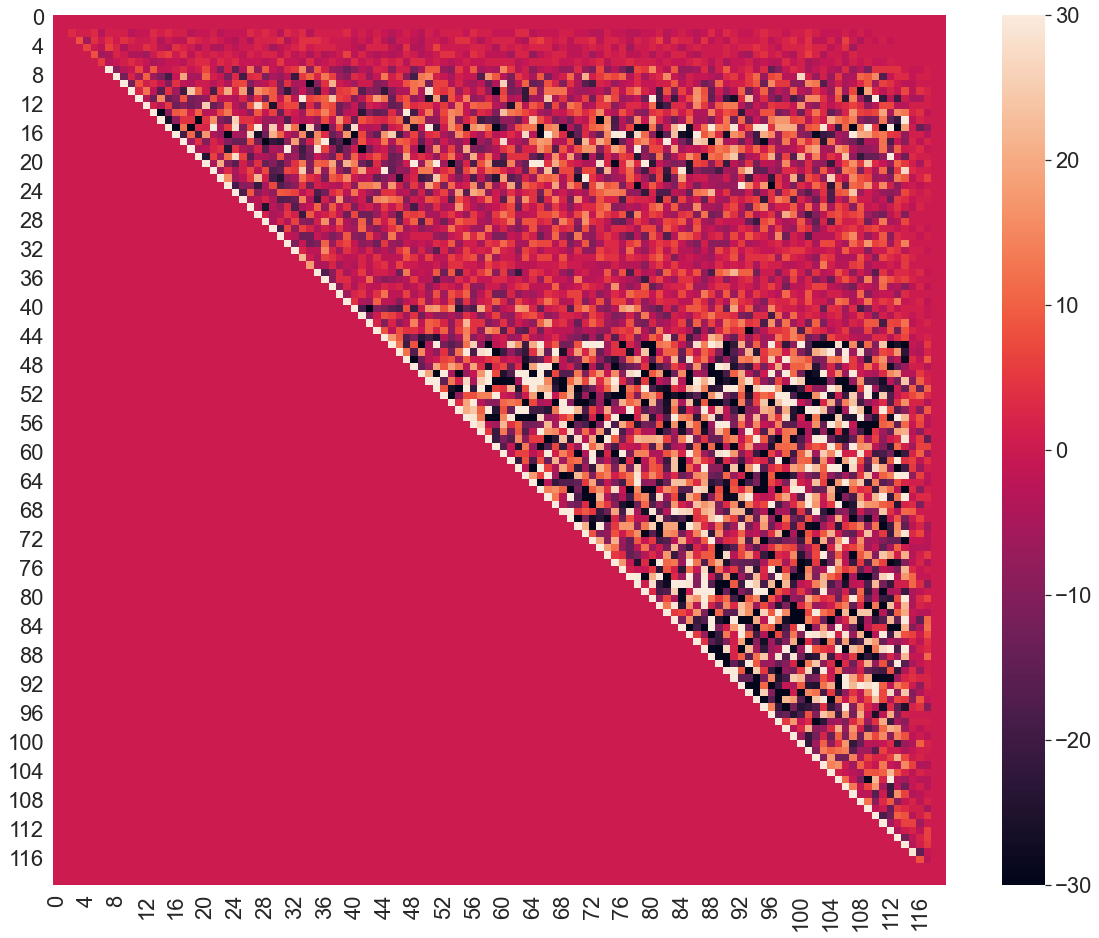

In [49]:
plt.figure(figsize=(20,16))
sns.set(font_scale=2)
sns.heatmap(final,vmax=30,vmin=-30,annot=False)



<AxesSubplot:>

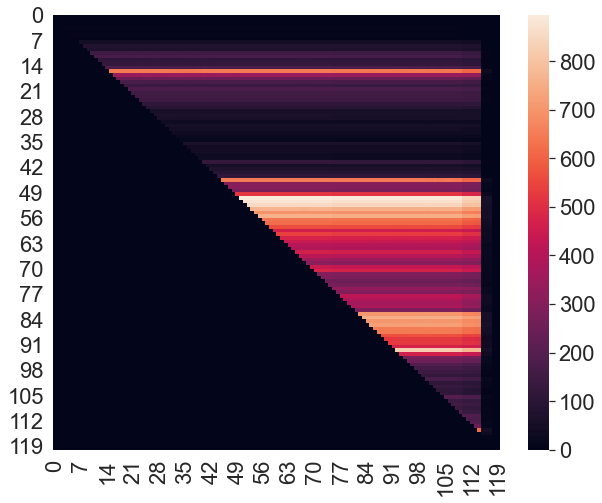

In [50]:
plt.figure(figsize=(10,8))

sns.heatmap(countFinal,annot=False,)


In [54]:
# float(input('Bias:')) 
biasPercentage = 65


consecutiveAndClose = 1
consecutiveOnly = 0

percentTimesCountedAtLeastMoreThan = 2

print(uniqueDaysCount,'Days ; ','Averages Multiplier :',avgMultiplier)
for i in range(len(final)):
    for j in range (i,len(final)):
        percentageHigherThanAvg = int(countFinal[i][j]/uniqueDaysCount *10000) /100
        if( percentageHigherThanAvg < percentTimesCountedAtLeastMoreThan ):
            continue
        prob = int(abs(final[i][j]) / countFinal[i][j] *10000)/100 + 50.00
        if (biasPercentage<prob<100)and (not i==j):
            if(j-i==1):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Consecutive') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Consecutive')
                continue

            if(j-i <= 120/timeFrame) and (not consecutiveOnly):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Close') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Close')
                continue

            if not(consecutiveAndClose or consecutiveOnly): 
                
                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg) if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg)




895 Days ;  Averages Multiplier : 1.2
7-8 01:24:00-01:36:00 70.0% -- 5.02 Consecutive
7-11 01:24:00-02:12:00 65.55% ++ 5.02 Close
7-13 01:24:00-02:36:00 70.0% ++ 5.02 Close
8-15 01:36:00-03:00:00 72.89% -- 9.27 Close
8-17 01:36:00-03:24:00 72.89% ++ 9.27 Close
9-10 01:48:00-02:00:00 67.14% -- 7.82 Consecutive
10-18 02:00:00-03:36:00 66.21000000000001% ++ 16.53 Close
12-20 02:24:00-04:00:00 71.73% ++ 12.84 Close
13-14 02:36:00-02:48:00 78.45% -- 13.74 Consecutive
14-19 02:48:00-03:48:00 66.85% -- 19.88 Close
19-20 03:48:00-04:00:00 67.39% -- 15.41 Consecutive
19-24 03:48:00-04:48:00 70.28% ++ 15.41 Close
22-30 04:24:00-06:00:00 65.58% -- 17.2 Close
24-25 04:48:00-05:00:00 66.07% -- 12.51 Consecutive
25-30 05:00:00-06:00:00 67.89% -- 10.61 Close
25-31 05:00:00-06:12:00 66.66% -- 10.72 Close
25-35 05:00:00-07:00:00 72.91% -- 10.72 Close
26-28 05:12:00-05:36:00 92.37% -- 6.59 Close
26-32 05:12:00-06:24:00 78.81% -- 6.59 Close
26-35 05:12:00-07:00:00 67.24% ++ 6.48 Close
27-33 05:24:00-06:3

In [52]:
uniqueDaysCount

895